In [43]:
from datasets import load_dataset

In [81]:
import gradio as gr
print(gr.__version__)

3.45.0


In [97]:
minds = load_dataset("PolyAI/minds14", name="ko-KR", split="train")

example = minds[0]

print(type(minds.features["intent_class"]))
print(example['path']) 
print(example['transcription'])
print(example['intent_class'])

<class 'datasets.features.features.ClassLabel'>
/storage/hf-datasets-cache/all/datasets/90720017063314-config-parquet-and-info-PolyAI-minds14-0f8c9bcc/downloads/extracted/73ab7f9ade76d3035add3081ab277e5bae46f3dbe75008135fea9e528746677a/ko-KR~ATM_LIMIT/602bef265f67b421554f65e7.wav
app Manager 하고 싶은데 최대 금액이 얼마인지요
3


In [84]:
from datasets import load_dataset_builder
dataset_builder = load_dataset_builder("PolyAI/minds14", name="ko-KR")
print(dataset_builder.cache_dir)

/home/ubuntu/.cache/huggingface/datasets/PolyAI___minds14/ko-KR/1.0.0/3a0bb29c446edbb0c461b27706cee1f3862191b8


In [85]:
id2label = minds.features["intent_class"].int2str
id2label(example["intent_class"])

'atm_limit'

In [86]:
#columns_to_remove = ["lang_id", "english_transcription"]
#minds = minds.remove_columns(columns_to_remove)
minds

Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
    num_rows: 592
})

In [87]:
columns_to_remove = ["lang_id", "english_transcription"]
minds = minds.remove_columns(columns_to_remove)
minds

Dataset({
    features: ['path', 'audio', 'transcription', 'intent_class'],
    num_rows: 592
})

In [7]:
#!chmod +x /usr/local/lib/python3.8/dist-packages/gradio/frpc_linux_amd64_v0.2

In [26]:
import gradio as gr

def generate_audio():
    example = minds.shuffle()[0]
    audio = example["audio"]
    return (
        audio["sampling_rate"],
        audio["array"],
    ), id2label(example["intent_class"]) + ": " + example['transcription']


with gr.Blocks() as demo:
    with gr.Column():
        for _ in range(5):
            audio, label = generate_audio()
            output = gr.Audio(audio, label=label)

demo.launch(debug=True, share=True)

/usr/local/lib/python3.10/dist-packages/gradio/processing_utils.py:183: UserWarning: Trying to convert audio automatically from float64 to 16-bit int format.
  warnings.warn(warning.format(data.dtype))


Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://49660f374ccc4be090.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://49660f374ccc4be090.gradio.live


In [21]:
#!pip install jinja2==3.0.1

8000


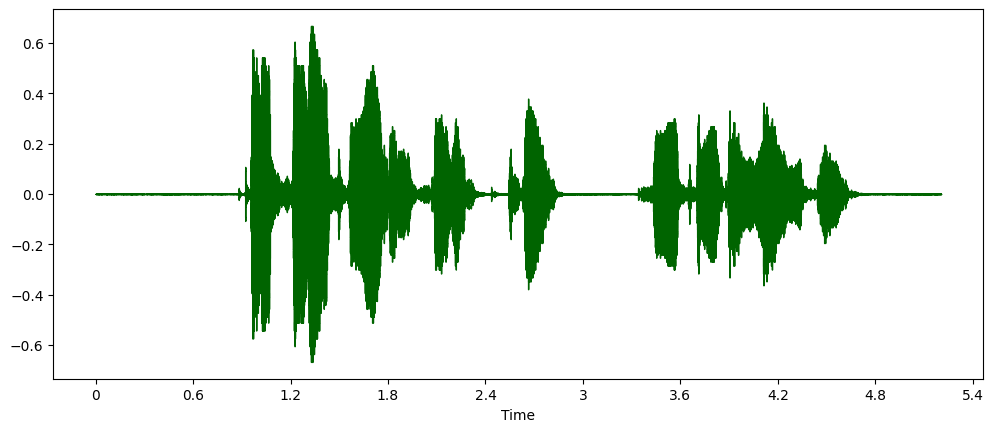

In [22]:
import librosa
import matplotlib.pyplot as plt
import librosa.display

array = example["audio"]["array"]
sampling_rate = example["audio"]["sampling_rate"]

print(sampling_rate)

plt.figure().set_figwidth(12)
#librosa.display.waveshow(array, sr=sampling_rate, color="orange")
librosa.display.waveshow(array, sr=sampling_rate,color="darkgreen" )

## resample the audio examples 

In [88]:
from datasets import Audio

#set the sampling rate to 16kHz
minds = minds.cast_column("audio", Audio(sampling_rate=16_000))

In [89]:
minds[0]

{'path': '/storage/hf-datasets-cache/all/datasets/90720017063314-config-parquet-and-info-PolyAI-minds14-0f8c9bcc/downloads/extracted/73ab7f9ade76d3035add3081ab277e5bae46f3dbe75008135fea9e528746677a/ko-KR~ATM_LIMIT/602bef265f67b421554f65e7.wav',
 'audio': {'path': '602bef265f67b421554f65e7.wav',
  'array': array([ 2.45040166e-04,  1.78244198e-04, -1.80276402e-06, ...,
          5.53574704e-04,  4.92824474e-04,  2.39125075e-04]),
  'sampling_rate': 16000},
 'transcription': 'app Manager 하고 싶은데 최대 금액이 얼마인지요',
 'intent_class': 3}

In [102]:
MAX_DURATION_IN_SECONDS = 20.0

def is_audio_length_in_range(input_length):
    return input_length < MAX_DURATION_IN_SECONDS

def calc_duration(minds):

    duration_seconds = []
    num_samples_too_long = 0
    #audio_data, sample_rate = librosa.load(audio_path, sr=None, mono=False)  # Use sr=None to preserve the original sample rate and mono=False to preserve stereo channels
    for audio_data in minds["audio"]:
        # Calculate the number of samples
        num_samples = len(audio_data["array"])   
        num_channel = 1
        sample_rate = audio_data["sampling_rate"]
        duration = num_samples / (sample_rate *  num_channel)
        #print(num_samples, num_channel, sample_rate, f"Duration of the audio file: {duration:.2f} seconds")

        if(duration > MAX_DURATION_IN_SECONDS): 
            num_samples_too_long += 1
            print(f" {num_samples_too_long}th sample: {duration:.2f} seconds")
        
        # Calculate the duration in minutes
        duration_seconds.append(duration)
    print(f"No. of samples_after_filtered: {len(minds) - num_samples_too_long }")
    
    return duration_seconds


In [103]:
# use librosa to get example's duration from the audio file
#new_column = [librosa.get_duration(path=x) for x in minds["path"]]
#new_column = [librosa.get_duration(path=x) for x in minds["path"]]
new_column = calc_duration(minds)

minds = minds.add_column("duration", new_column)

# use 🤗 Datasets' `filter` method to apply the filtering function
minds = minds.filter(is_audio_length_in_range, input_columns=["duration"])

# remove the temporary helper column
minds = minds.remove_columns(["duration"])
minds

No. of samples_after_filtered: 563


Flattening the indices:   0%|          | 0/563 [00:00<?, ? examples/s]

Filter:   0%|          | 0/563 [00:00<?, ? examples/s]

Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
    num_rows: 563
})

In [104]:
new_column = calc_duration(minds)

No. of samples_after_filtered: 563
